In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
import optuna
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import sklearn.metrics as metrics
import seaborn as sns
import pickle
from sklearn.pipeline import make_pipeline
import warnings
import shap

shap.initjs()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
# read data

df=pd.read_csv('preprocessed_train.csv')
df

,Airline,Source,Destination,Total_Stops,Price,Dep_Hour,Dep_Min,Arrival_Hour,Arrival_Min,Date,Month,Duration_Hours,Duration_Mins,Weekday,day/night
0,IndiGo,Banglore,Delhi,0,3897,22,20,1,10,24,3,2.0,50,7,5.0
1,Air India,Kolkata,Banglore,2,7662,5,50,13,15,5,1,7.0,25,6,1.0
2,Jet Airways,Delhi,Cochin,2,13882,9,25,4,25,6,9,19.0,0,5,2.0
3,IndiGo,Kolkata,Banglore,1,6218,18,5,23,30,5,12,5.0,25,4,4.0
4,IndiGo,Banglore,Delhi,1,13302,16,50,21,35,3,1,4.0,45,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10676,Air Asia,Kolkata,Banglore,0,4107,19,55,22,25,4,9,2.0,30,3,4.0
10677,Air India,Kolkata,Banglore,0,4145,20,45,23,20,27,4,2.0,35,6,5.0
10678,Jet Airways,Banglore,Delhi,0,7229,8,20,11,20,27,4,3.0,0,6,2.0
10679,Vistara,Banglore,Delhi,0,12648,11,30,14,10,3,1,2.0,40,4,2.0


In [3]:
X=df.drop('Price',axis=1)
y=df['Price']

In [4]:
# train test split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=15)


In [5]:
# encoding categorical columns

encoder=ce.TargetEncoder()

X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

pickle.dump(encoder,open('encoder.pkl','wb'))

In [6]:
class Model:
    
    def __init__(self,model):
        self.model=model
        
    def train(self):
        result=self.model.fit(X_train,y_train)
        prediction=result.predict(X_test)
        print('TRAIN SCORE = ',result.score(X_train,y_train))
        print('--------------------------------=---------------------------------')  
        print('TEST SCORE = ',result.score(X_test,y_test))
        print('-----------------------------------------------------------------') 
        print('TEST MAE =',metrics.mean_absolute_error(y_test,prediction))
        print('-----------------------------------------------------------------')
        print('TEST MSE = ',metrics.mean_squared_error(y_test,prediction))
        print('-----------------------------------------------------------------')
        print('TEST RMSE = ',np.sqrt(metrics.mean_squared_error(y_test, prediction)))
        print('-----------------------------------------------------------------') 
        plot_model(y_test,prediction)
        
        return pd.DataFrame({'ACTUAL':y_test,'PREDICTED':prediction})
        
    def features(self):
        feat_imp = pd.Series(self.model.feature_importances_, index=X_train.columns)
        features = feat_imp.nlargest(20)
        features.plot(kind='barh')
        plt.title('IMPORTANT FEATURES')
        plt.show()
    
    def save_model(self):
        pickle.dump(self.model,open('model.pkl','wb'))


def plot_model(y,prediction):
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.title('RESIDUAL PLOT')
    sns.histplot(y-prediction,kde=True,color='green')
    
    plt.subplot(1,2,2)
    plt.title('REGRESSION PLOT')
    sns.regplot(x=y,y=prediction,scatter_kws={'color':'black'},line_kws={'color':'red'})

TRAIN SCORE =  0.6073449557710925
--------------------------------=---------------------------------
TEST SCORE =  0.6271720211279478
-----------------------------------------------------------------
TEST MAE = 1944.0260317911507
-----------------------------------------------------------------
TEST MSE =  6668820.468634294
-----------------------------------------------------------------
TEST RMSE =  2582.4059457479366
-----------------------------------------------------------------


,ACTUAL,PREDICTED
8732,8529,10793.506151
4819,11134,10910.918005
687,8937,11609.908314
10601,5636,7778.272718
4795,10844,11793.474638
...,...,...
2565,14120,13379.642367
6409,12127,10878.409489
2172,10703,13713.587726
9735,5899,6806.049622


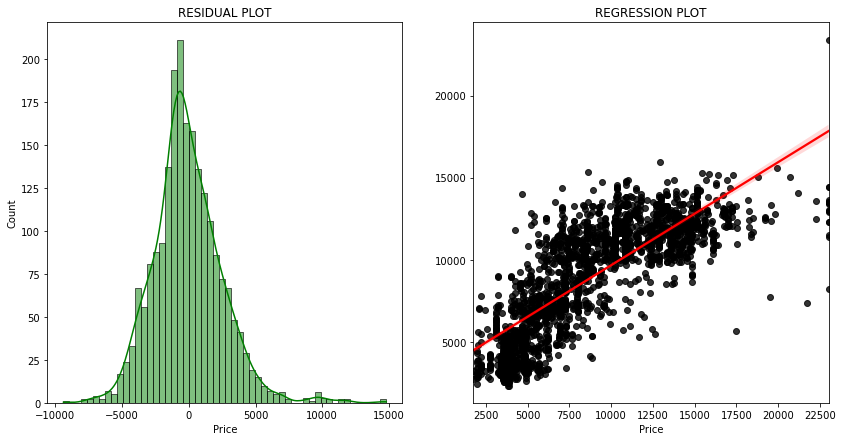

In [7]:
## linear regression

lr=make_pipeline(PowerTransformer(),LinearRegression())
m=Model(lr)
m.train()

TRAIN SCORE =  0.6073446872029036
--------------------------------=---------------------------------
TEST SCORE =  0.6271538379844863
-----------------------------------------------------------------
TEST MAE = 1943.8220658413907
-----------------------------------------------------------------
TEST MSE =  6669145.712784873
-----------------------------------------------------------------
TEST RMSE =  2582.468918067529
-----------------------------------------------------------------


,ACTUAL,PREDICTED
8732,8529,10794.123160
4819,11134,10907.948749
687,8937,11612.285961
10601,5636,7784.264621
4795,10844,11791.563036
...,...,...
2565,14120,13371.608412
6409,12127,10875.546409
2172,10703,13718.129155
9735,5899,6809.675398


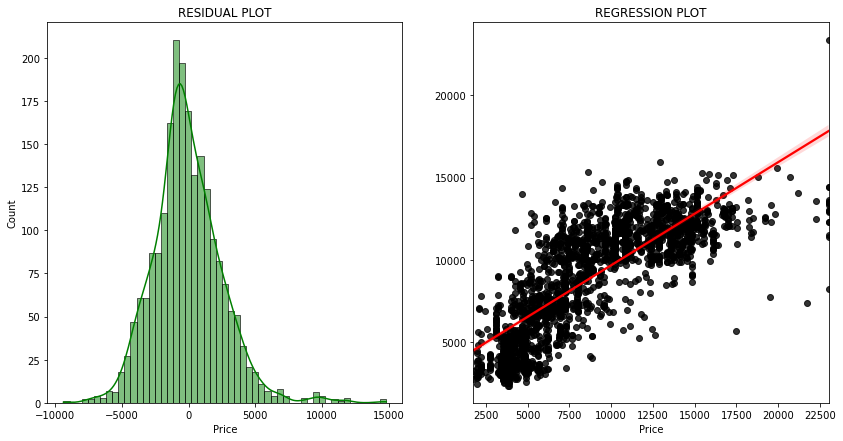

In [8]:
## lasso

lasso=make_pipeline(PowerTransformer(),Lasso())
m=Model(lasso)
m.train()

## HYPERPARAMETER TUNING

In [9]:
def objective(trial):
    # define parameters' sample space and sample type
#     min_samples_leaf  = trial.suggest_int('min_samples_leaf',1,70)
#     min_samples_split = trial.suggest_int('min_samples_split',2,10)
#     max_leaf_nodes = trial.suggest_int('max_leaf_nodes',10,100)
    n_estimators = trial.suggest_int('n_estimators',10,200) 
#     max_samples= trial.suggest_float('max_samples',0,1)
    max_depth = trial.suggest_int('max_depth',1,70) 

    reg = RandomForestRegressor(n_estimators=n_estimators,
#                                 min_samples_leaf=min_samples_leaf,
#                                 min_samples_split = min_samples_split,
                                max_depth=max_depth,
#                                 max_samples=max_samples,
#                                 max_leaf_nodes=max_leaf_nodes,
                                random_state=15,oob_score=True)


    reg.fit(X_train,y_train)
    
    return cross_val_score(reg,X_test,y_test,n_jobs=-1,cv=5,scoring='neg_mean_squared_error').mean()

# create study
study = optuna.create_study(direction='maximize')
# run study to find best objective
study.optimize(objective,n_trials=200)
rf_params=study.best_params
print('Best model parameters:{} '.format(study.best_params))
print('Best score: {:.6f}'.format(study.best_value))

[I 2021-12-02 20:46:24,157] A new study created in memory with name: no-name-5ea7cce2-2108-4506-af09-e8968f96aafd
[I 2021-12-02 20:46:28,938] Trial 0 finished with value: -3668881.539729574 and parameters: {'n_estimators': 144, 'max_depth': 69}. Best is trial 0 with value: -3668881.539729574.
[I 2021-12-02 20:46:31,772] Trial 1 finished with value: -3694270.909877087 and parameters: {'n_estimators': 66, 'max_depth': 36}. Best is trial 0 with value: -3668881.539729574.
[I 2021-12-02 20:46:34,076] Trial 2 finished with value: -3708136.0062507736 and parameters: {'n_estimators': 54, 'max_depth': 43}. Best is trial 0 with value: -3668881.539729574.
[I 2021-12-02 20:46:38,046] Trial 3 finished with value: -3676186.435875369 and parameters: {'n_estimators': 177, 'max_depth': 59}. Best is trial 0 with value: -3668881.539729574.
[I 2021-12-02 20:46:38,896] Trial 4 finished with value: -3706935.2714913585 and parameters: {'n_estimators': 42, 'max_depth': 15}. Best is trial 0 with value: -366888

[I 2021-12-02 20:48:03,880] Trial 42 finished with value: -3667344.992609583 and parameters: {'n_estimators': 87, 'max_depth': 51}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:48:06,197] Trial 43 finished with value: -3685690.527066932 and parameters: {'n_estimators': 102, 'max_depth': 61}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:48:07,744] Trial 44 finished with value: -3692678.206793369 and parameters: {'n_estimators': 69, 'max_depth': 51}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:48:09,630] Trial 45 finished with value: -3668782.5667137904 and parameters: {'n_estimators': 84, 'max_depth': 66}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:48:12,594] Trial 46 finished with value: -3676688.4654713697 and parameters: {'n_estimators': 129, 'max_depth': 48}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:48:13,928] Trial 47 finished with value: -3716619.41831587 and parame

[I 2021-12-02 20:49:22,602] Trial 84 finished with value: -3689386.4280891838 and parameters: {'n_estimators': 70, 'max_depth': 68}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:49:24,546] Trial 85 finished with value: -3667344.992609583 and parameters: {'n_estimators': 87, 'max_depth': 54}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:49:26,634] Trial 86 finished with value: -3678570.305367943 and parameters: {'n_estimators': 94, 'max_depth': 54}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:49:30,112] Trial 87 finished with value: -3674864.525176184 and parameters: {'n_estimators': 156, 'max_depth': 58}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:49:32,010] Trial 88 finished with value: -3669452.419448377 and parameters: {'n_estimators': 79, 'max_depth': 51}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:49:34,325] Trial 89 finished with value: -3687900.650266728 and paramet

[I 2021-12-02 20:50:42,764] Trial 126 finished with value: -3668586.933854463 and parameters: {'n_estimators': 89, 'max_depth': 50}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:50:44,655] Trial 127 finished with value: -3665530.6913201725 and parameters: {'n_estimators': 85, 'max_depth': 58}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:50:46,570] Trial 128 finished with value: -3668078.065392169 and parameters: {'n_estimators': 86, 'max_depth': 29}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:50:50,695] Trial 129 finished with value: -3678616.6685976847 and parameters: {'n_estimators': 185, 'max_depth': 58}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:50:53,040] Trial 130 finished with value: -3680732.284705919 and parameters: {'n_estimators': 100, 'max_depth': 57}. Best is trial 24 with value: -3665530.6913201725.
[I 2021-12-02 20:50:55,116] Trial 131 finished with value: -3681081.5962958024 an

[I 2021-12-02 20:52:10,052] Trial 168 finished with value: -3622640.8178199963 and parameters: {'n_estimators': 131, 'max_depth': 13}. Best is trial 138 with value: -3620443.2208515517.
[I 2021-12-02 20:52:12,548] Trial 169 finished with value: -3622640.8178199963 and parameters: {'n_estimators': 131, 'max_depth': 13}. Best is trial 138 with value: -3620443.2208515517.
[I 2021-12-02 20:52:14,949] Trial 170 finished with value: -3623584.022166756 and parameters: {'n_estimators': 130, 'max_depth': 13}. Best is trial 138 with value: -3620443.2208515517.
[I 2021-12-02 20:52:17,350] Trial 171 finished with value: -3622640.8178199963 and parameters: {'n_estimators': 131, 'max_depth': 13}. Best is trial 138 with value: -3620443.2208515517.
[I 2021-12-02 20:52:19,824] Trial 172 finished with value: -3622640.8178199963 and parameters: {'n_estimators': 131, 'max_depth': 13}. Best is trial 138 with value: -3620443.2208515517.
[I 2021-12-02 20:52:22,433] Trial 173 finished with value: -3624378.405

Best model parameters:{'n_estimators': 92, 'max_depth': 13} 
Best score: -3620443.220852


TRAIN SCORE =  0.9264935392286857
--------------------------------=---------------------------------
TEST SCORE =  0.8647041674626108
-----------------------------------------------------------------
TEST MAE = 1080.0088860546025
-----------------------------------------------------------------
TEST MSE =  2420053.3985564956
-----------------------------------------------------------------
TEST RMSE =  1555.652081461821
-----------------------------------------------------------------


,ACTUAL,PREDICTED
8732,8529,10311.166692
4819,11134,13202.137158
687,8937,9241.819326
10601,5636,5973.938603
4795,10844,12753.775082
...,...,...
2565,14120,12375.390747
6409,12127,10336.163893
2172,10703,10990.548761
9735,5899,6829.133381


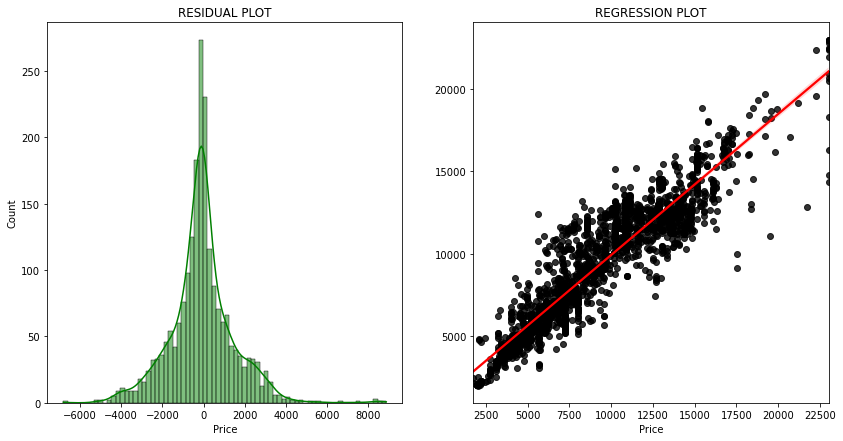

In [10]:
## random forest regressor

rf=RandomForestRegressor(**rf_params,random_state=15)
r=Model(rf)
r.train()

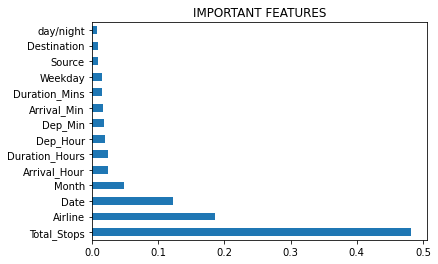

In [14]:
r.features()

In [11]:
def objective(trial):

    boosting_type  = trial.suggest_categorical('boosting_type',['dart'])
#     num_leaves = trial.suggest_int('num_leaves',10,50)
    learning_rate  = trial.suggest_loguniform('learning_rate',1e-2,2.5)
    n_estimators = trial.suggest_int('n_estimators',10,200) 
    max_depth = trial.suggest_int('max_depth',1,20)

    reg = make_pipeline(PowerTransformer(),LGBMRegressor(n_estimators=n_estimators,
                                boosting_type=boosting_type,
#                                 num_leaves = num_leaves,
                                max_depth=max_depth,
                                learning_rate=learning_rate,random_state=15))


    reg.fit(X_train,y_train)
    
    return cross_val_score(reg,X_test,y_test,n_jobs=-1,cv=5,scoring='neg_mean_squared_error').mean()

# create study
study = optuna.create_study(direction='maximize')
# run study to find best objective
study.optimize(objective,n_trials=200)
lgbm_params=study.best_params
print('Best model parameters:{} '.format(study.best_params))
print('Best score: {:.6f}'.format(study.best_value))

[I 2021-12-02 20:53:40,621] A new study created in memory with name: no-name-678bd1c3-94d2-4cee-8028-9b667a228743
[I 2021-12-02 20:53:40,936] Trial 0 finished with value: -16794860.463865835 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.030764101143512093, 'n_estimators': 71, 'max_depth': 7}. Best is trial 0 with value: -16794860.463865835.
[I 2021-12-02 20:53:41,383] Trial 1 finished with value: -3872497.403188654 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.41361577567229746, 'n_estimators': 127, 'max_depth': 10}. Best is trial 1 with value: -3872497.403188654.
[I 2021-12-02 20:53:42,080] Trial 2 finished with value: -13039680.333373094 and parameters: {'boosting_type': 'dart', 'learning_rate': 2.039279682900271, 'n_estimators': 175, 'max_depth': 18}. Best is trial 1 with value: -3872497.403188654.
[I 2021-12-02 20:53:42,332] Trial 3 finished with value: -20919234.39668522 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0253007786142133, 'n

[I 2021-12-02 20:53:52,950] Trial 32 finished with value: -3801144.3438208485 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.18814957936841345, 'n_estimators': 126, 'max_depth': 13}. Best is trial 15 with value: -3745881.1493072906.
[I 2021-12-02 20:53:53,320] Trial 33 finished with value: -3761419.2453508237 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.16629546410597865, 'n_estimators': 121, 'max_depth': 9}. Best is trial 15 with value: -3745881.1493072906.
[I 2021-12-02 20:53:53,697] Trial 34 finished with value: -4490890.726083973 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.07364146673972641, 'n_estimators': 120, 'max_depth': 9}. Best is trial 15 with value: -3745881.1493072906.
[I 2021-12-02 20:53:54,098] Trial 35 finished with value: -4024552.5309262746 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.5782959480739689, 'n_estimators': 131, 'max_depth': 16}. Best is trial 15 with value: -3745881.1493072906.
[I 2021-12-02 20

[I 2021-12-02 20:54:06,047] Trial 64 finished with value: -3850276.6275789044 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.14180262957268078, 'n_estimators': 144, 'max_depth': 9}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54:06,582] Trial 65 finished with value: -3787077.538446893 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.28178795248720384, 'n_estimators': 183, 'max_depth': 7}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54:07,044] Trial 66 finished with value: -3838437.0332640507 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.19126962324995445, 'n_estimators': 154, 'max_depth': 13}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54:07,565] Trial 67 finished with value: -3990549.5955889397 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.6565049520455055, 'n_estimators': 191, 'max_depth': 12}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20

[I 2021-12-02 20:54:19,295] Trial 96 finished with value: -3820787.7823979147 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2014458617925096, 'n_estimators': 115, 'max_depth': 13}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54:19,646] Trial 97 finished with value: -3831102.4289468946 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.126334769161216, 'n_estimators': 112, 'max_depth': 12}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54:20,146] Trial 98 finished with value: -3756400.5126701295 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.35097306391717176, 'n_estimators': 177, 'max_depth': 8}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54:20,675] Trial 99 finished with value: -3755272.556890036 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.3590585536284302, 'n_estimators': 176, 'max_depth': 8}. Best is trial 40 with value: -3709631.3769280436.
[I 2021-12-02 20:54

[I 2021-12-02 20:54:35,427] Trial 128 finished with value: -3775554.063171497 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2448747381826708, 'n_estimators': 163, 'max_depth': 11}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 20:54:35,872] Trial 129 finished with value: -3815132.000524111 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2694337733501995, 'n_estimators': 155, 'max_depth': 12}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 20:54:36,438] Trial 130 finished with value: -13795857.793800686 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.017600184743660905, 'n_estimators': 188, 'max_depth': 11}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 20:54:36,898] Trial 131 finished with value: -3755726.627738615 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.30089823923327474, 'n_estimators': 150, 'max_depth': 10}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-0

[I 2021-12-02 20:54:51,458] Trial 160 finished with value: -3799854.485108701 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.16303683400577257, 'n_estimators': 183, 'max_depth': 10}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 20:54:52,049] Trial 161 finished with value: -3776824.594206378 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.319945063934297, 'n_estimators': 157, 'max_depth': 11}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 20:54:52,648] Trial 162 finished with value: -3748639.8230411494 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.236019861696027, 'n_estimators': 171, 'max_depth': 9}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 20:54:53,155] Trial 163 finished with value: -3732336.5931157237 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.20247616180013586, 'n_estimators': 179, 'max_depth': 10}. Best is trial 122 with value: -3706795.809806322.
[I 2021-12-02 2

[I 2021-12-02 20:55:07,107] Trial 192 finished with value: -3772845.071257055 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.26001476009216373, 'n_estimators': 159, 'max_depth': 9}. Best is trial 179 with value: -3698449.881113091.
[I 2021-12-02 20:55:07,550] Trial 193 finished with value: -3756034.5449018804 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.29681137104047683, 'n_estimators': 152, 'max_depth': 9}. Best is trial 179 with value: -3698449.881113091.
[I 2021-12-02 20:55:08,048] Trial 194 finished with value: -3780370.9025878734 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.3207497148249244, 'n_estimators': 175, 'max_depth': 9}. Best is trial 179 with value: -3698449.881113091.
[I 2021-12-02 20:55:08,516] Trial 195 finished with value: -3798914.5105409115 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.43999250319290056, 'n_estimators': 168, 'max_depth': 7}. Best is trial 179 with value: -3698449.881113091.
[I 2021-12-02 

Best model parameters:{'boosting_type': 'dart', 'learning_rate': 0.29532428729787835, 'n_estimators': 169, 'max_depth': 12} 
Best score: -3698449.881113


TRAIN SCORE =  0.902071875041649
--------------------------------=---------------------------------
TEST SCORE =  0.8674871960670024
-----------------------------------------------------------------
TEST MAE = 1097.2503185042733
-----------------------------------------------------------------
TEST MSE =  2370273.0194714502
-----------------------------------------------------------------
TEST RMSE =  1539.5691018825528
-----------------------------------------------------------------


,ACTUAL,PREDICTED
8732,8529,10494.117790
4819,11134,12133.382614
687,8937,9827.388088
10601,5636,6172.286187
4795,10844,12882.685141
...,...,...
2565,14120,12697.221674
6409,12127,10896.339904
2172,10703,11256.480679
9735,5899,6249.230242


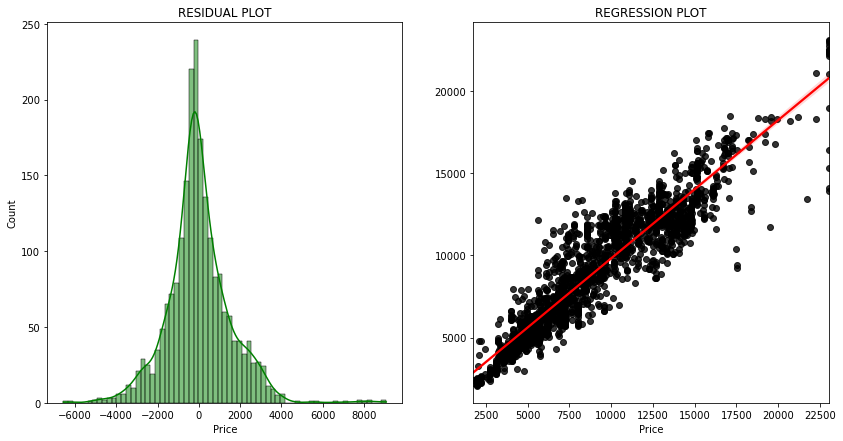

In [13]:
## lightgbm regressor

lgbm=LGBMRegressor(**lgbm_params,random_state=15)
l=Model(lgbm)
l.train()

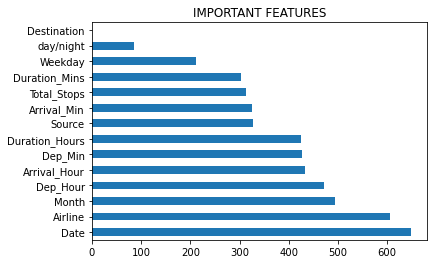

In [15]:
l.features()
l.save_model()

### SHAP

In [16]:
explainer=shap.TreeExplainer(lgbm)
shap_values=explainer.shap_values(X_test)

In [17]:
shap.force_plot(explainer.expected_value,shap_values[1,:],X_test.iloc[1,:])

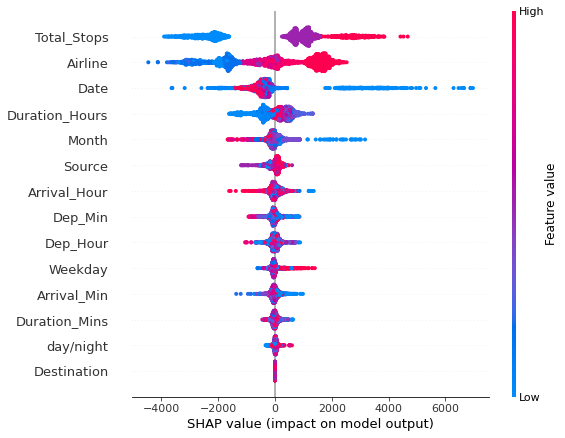

In [18]:
shap.summary_plot(shap_values,X_test)

In [19]:
# loading the test data, encoding and scaling the data

df2=pd.read_csv('preprocessed_test.csv')

X_new=df2
X_new=encoder.transform(X_new)


In [21]:
# prediction on transformed test data

loaded_model=pickle.load(open('model.pkl','rb'))
new_predictions=loaded_model.predict(X_new)
new_predictions=pd.DataFrame(new_predictions,columns=['Price'])
new_predictions

,Price
0,11558.973747
1,4835.398403
2,13889.449467
3,10230.027945
4,4220.085882
...,...
2665,9332.539956
2666,4541.262670
2667,16084.459653
2668,13346.281157
